In [1]:
import os
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import json
import sys
sys.path.append('..')

from utils.dlt import *
from utils.files import FileName
from utils.skeleton_keypoints import *
from utils.motion_visualize_tool import *
from config import *

### Calibration Cube

In [2]:
with open("cube_data/subsets.json", "r") as f:
    subsets = json.load(f)

imgpoints = []
for i in [1, 2]:
    imgpoints.append(subsets[f"cam{i}.mp4"])
imgpoints = np.array(imgpoints, dtype=np.float32)
print(imgpoints.shape)
imgpoints

(2, 8, 2)


array([[[ 588.,  657.],
        [ 744.,  705.],
        [ 844.,  681.],
        [ 688.,  640.],
        [ 588.,  542.],
        [ 744.,  573.],
        [ 847.,  559.],
        [ 688.,  530.]],

       [[1248.,  736.],
        [1106.,  758.],
        [1173.,  775.],
        [1317.,  751.],
        [1248.,  648.],
        [1104.,  662.],
        [1173.,  674.],
        [1317.,  657.]]], dtype=float32)

In [3]:
with open("cube_data/3d_points.json", "r") as f:
    points = json.load(f)
cube_3d = np.array(points["object_point"], dtype=np.float32)
objpoints = np.array([cube_3d for _ in range(len(imgpoints))] , dtype=np.float32)
print(objpoints.shape)
objpoints

(2, 8, 3)


array([[[  0.,   0.,   0.],
        [940.,   0.,   0.],
        [940., 450.,   0.],
        [  0., 450.,   0.],
        [  0.,   0., 450.],
        [940.,   0., 450.],
        [940., 450., 450.],
        [  0., 450., 450.]],

       [[  0.,   0.,   0.],
        [940.,   0.,   0.],
        [940., 450.,   0.],
        [  0., 450.,   0.],
        [  0.,   0., 450.],
        [940.,   0., 450.],
        [940., 450., 450.],
        [  0., 450., 450.]]], dtype=float32)

In [4]:
print(f"imgpoints: {imgpoints.shape}")
print(f"objpoints: {objpoints.shape}")

imgpoints: (2, 8, 2)
objpoints: (2, 8, 3)


In [5]:
cam = 2

p1 = prepare_matrix(imgpoints[0], objpoints[0])
p2 = prepare_matrix(imgpoints[1], objpoints[1])
# p3 = prepare_matrix(imgpoints[2], objpoints[2])
# p4 = prepare_matrix(imgpoints[3], objpoints[3])
P = np.array([p1, p2], dtype=np.float32)

cube_array = pose_recon_2c(cam, P, imgpoints)
cube_array

array([[-1.33548287e+00, -7.73608518e-01,  1.55854099e+00],
       [ 9.41006342e+02,  1.69748865e+00, -4.16332105e-01],
       [ 9.39641747e+02,  4.48106751e+02,  6.55618857e-01],
       [ 5.65903984e-01,  4.50886260e+02, -1.81011205e+00],
       [-2.35569337e-01,  1.14100665e+00,  4.47889989e+02],
       [ 9.40462586e+02, -2.24247640e+00,  4.50958272e+02],
       [ 9.38975555e+02,  4.52463241e+02,  4.48856318e+02],
       [ 9.32129425e-01,  4.48712560e+02,  4.52308371e+02]])

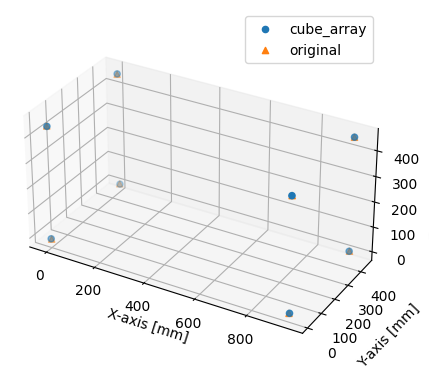

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cube_array[:, 0], cube_array[:, 1], cube_array[:, 2], marker='o', label='cube_array')
ax.scatter(cube_3d[:, 0], cube_3d[:, 1], cube_3d[:, 2], marker='^', label='original')
ax.set_xlabel('X-axis [mm]')
ax.set_ylabel('Y-axis [mm]')
ax.set_zlabel('Z-axis [mm]')
ax.legend()
ax.set_aspect('equal')
plt.show()

### Pose Estimation

In [7]:
test_case = "test/test1"
df1 = pd.read_csv(os.path.join(test_case, "cam1_0.mp4", "position_data.csv"))
df2 = pd.read_csv(os.path.join(test_case, "cam2_0.mp4", "position_data.csv"))

width = 1920
height = 1080

cols = []
for key, value in KEYPOINTS.items():
    cols.append(f"{key}_x")
    cols.append(f"{key}_y")
cam1_position = df1[cols].copy()
cam2_position = df2[cols].copy()
print(cam1_position.shape, cam2_position.shape)

(332, 34) (362, 34)


最大相関のラグ: 22 フレーム


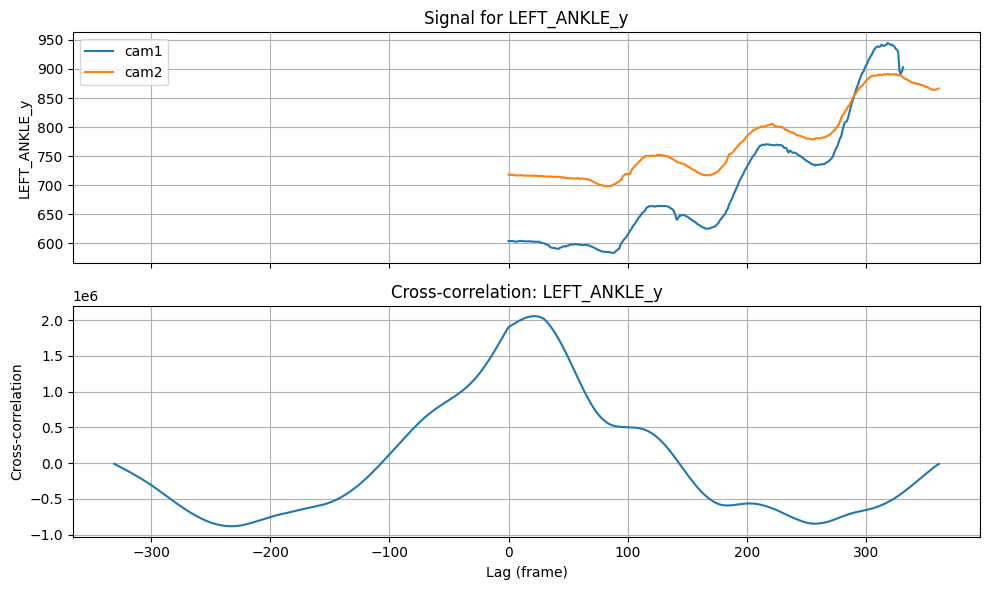

同期後のデータ数: 310, 288


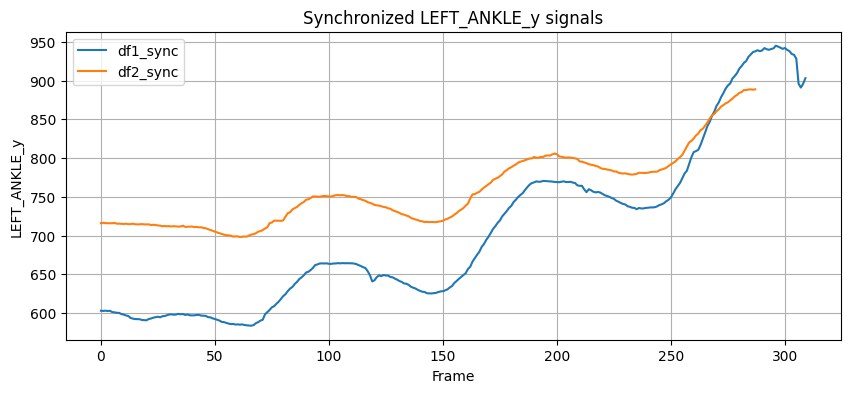

In [8]:
df1_sync, df2_sync, time_lag = sync_and_plot_keypoint(cam1_position, cam2_position, 'LEFT_ANKLE_y')


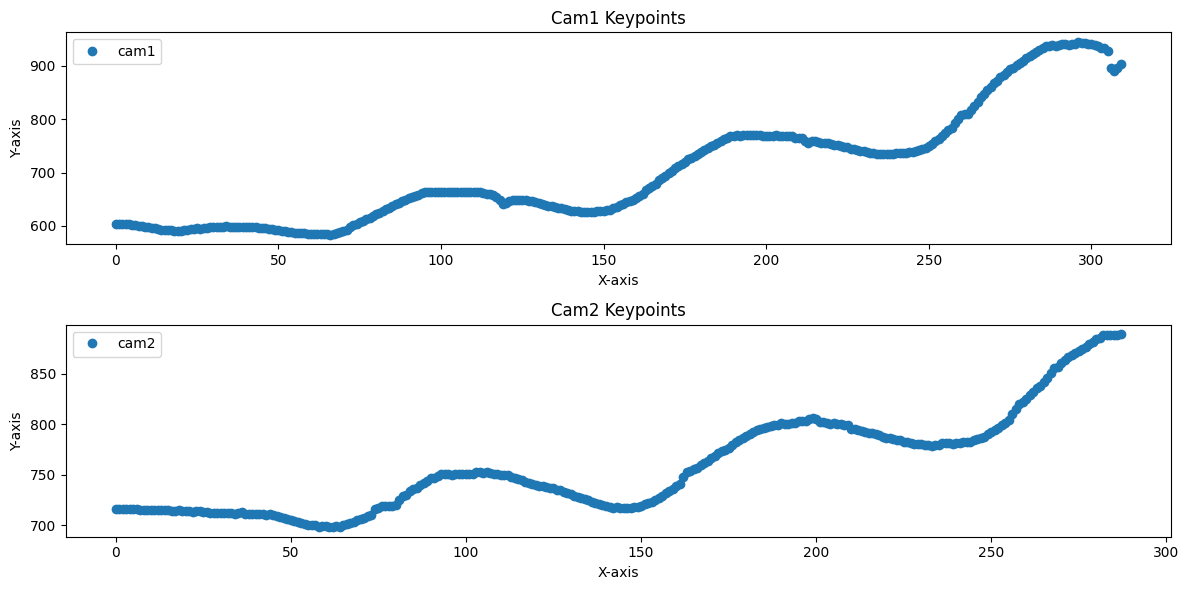

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
ax[0].plot(df1_sync.index, df1_sync['LEFT_ANKLE_y'], 'o', label='cam1')
ax[0].set_title('Cam1 Keypoints')
ax[1].plot(df2_sync.index, df2_sync['LEFT_ANKLE_y'], 'o', label='cam2')
ax[1].set_title('Cam2 Keypoints')
ax[0].set_xlabel('X-axis')
ax[0].set_ylabel('Y-axis')
ax[1].set_xlabel('X-axis')
ax[1].set_ylabel('Y-axis')
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.show()

In [16]:
cam1_position["ID"] = cam1_position.index
cam2_position["ID"] = cam2_position.index
cam1_position = cam1_position.loc[cam1_position["ID"] > 0]
cam2_position = cam2_position.loc[cam2_position["ID"] > 0]

In [17]:
cam1_position.set_index("ID", inplace=True, drop=True)
cam2_position.set_index("ID", inplace=True, drop=True)

In [18]:
col = [c for c in cam1_position.columns if '_x' not in c]
key_point = [c.replace('_y', '') for c in col]

In [19]:
cols = [c for c in cam1_position.columns if any(k in c for k in key_point)]

cam1_position = cam1_position[cols]
cam2_position = cam2_position[cols]
print(cam1_position.shape, cam2_position.shape)
cam1_position

(331, 34) (361, 34)


,NOSE_x,NOSE_y,LEFT_EYE_x,LEFT_EYE_y,RIGHT_EYE_x,RIGHT_EYE_y,LEFT_EAR_x,LEFT_EAR_y,RIGHT_EAR_x,RIGHT_EAR_y,...,RIGHT_HIP_x,RIGHT_HIP_y,LEFT_KNEE_x,LEFT_KNEE_y,RIGHT_KNEE_x,RIGHT_KNEE_y,LEFT_ANKLE_x,LEFT_ANKLE_y,RIGHT_ANKLE_x,RIGHT_ANKLE_y
ID,,,,,,,,,,,,,,,,,,,,,
1,701.71344,258.02222,709.34906,248.09587,694.07776,245.80518,713.1669,244.27805,668.11650,235.11526,...,624.59330,403.86322,654.37240,510.76236,630.70184,509.99880,628.41113,603.91736,607.79486,609.26230
2,701.85980,258.04428,709.49930,248.11287,694.98420,245.82100,713.3191,244.29309,669.00964,235.12561,...,624.70026,403.95984,654.49450,511.67760,630.81190,511.67760,628.52000,604.11630,607.89320,609.46400
3,703.02370,257.99478,709.90137,248.82455,695.38184,245.76780,713.7223,244.23944,669.39954,235.83340,...,625.07680,403.95416,654.88007,511.70428,631.19030,511.70428,628.89777,604.17070,607.50055,609.52000
4,702.99000,258.09283,710.63574,248.91791,695.34420,245.85960,714.4586,245.09503,669.34863,235.92012,...,625.00323,404.12683,655.58624,511.16748,631.88440,511.16748,628.82610,603.68120,607.41797,609.03320
5,703.68365,258.31750,710.55770,249.15213,696.04584,246.09700,714.3766,245.33322,670.07730,236.16785,...,625.77800,404.19970,655.56540,511.12906,631.88824,510.36526,628.83310,603.54660,608.21100,608.89307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,1907.75010,296.89610,1877.73880,296.89610,1823.92530,296.89610,1916.0290,296.89610,2134.38750,296.89610,...,1916.02900,600.11410,1958.45890,786.39136,1954.31930,789.49600,1902.57570,928.16907,1833.23910,883.66950
328,1907.54700,595.62823,1853.85840,506.14722,1908.54110,330.16794,2129.2610,915.77130,2129.26100,330.16794,...,1915.50090,597.61670,1932.40280,811.37683,1926.43740,804.41720,1904.56420,895.88666,1845.90450,888.92700
329,1909.02150,633.03880,1738.28830,537.35320,2121.96880,379.75342,1920.2786,379.75342,1919.34060,379.75342,...,1921.21670,595.51510,1944.66910,769.06250,1931.53580,756.86725,1890.25960,891.01470,1870.55960,897.58136


In [21]:
min_frame = max(cam1_position.index.min(), cam2_position.index.min())
max_frame = min(cam1_position.index.max(), cam2_position.index.max())

print(min_frame, max_frame)

1 331


In [22]:
frame = min_frame  # Use integer division to get a valid frame index
cam1_pose = cam1_position.loc[frame].values.reshape(-1, 2)  # Use -1 to infer the correct shape
cam2_pose = cam2_position.loc[frame].values.reshape(-1, 2)  # Use -1 to infer the correct shape

print(f"Frame: {frame}")
cam1_pose

Frame: 1


array([[701.71344, 258.02222],
       [709.34906, 248.09587],
       [694.07776, 245.80518],
       [713.1669 , 244.27805],
       [668.1165 , 235.11526],
       [706.2948 , 289.3284 ],
       [626.88403, 283.21988],
       [703.24054, 344.3051 ],
       [596.3414 , 345.83224],
       [719.2754 , 400.80896],
       [626.1204 , 402.3361 ],
       [666.5894 , 409.97174],
       [624.5933 , 403.86322],
       [654.3724 , 510.76236],
       [630.70184, 509.9988 ],
       [628.41113, 603.91736],
       [607.79486, 609.2623 ]])

In [23]:
pose = np.array([cam1_pose, cam2_pose], dtype=np.float32)
pose_result = pose_recon_2c(cam, P, pose)
pose_result

array([[ 235.50613008,  336.86192282, 1504.42387292],
       [ 233.79743028,  372.27765449, 1544.23115346],
       [ 230.84160696,  305.58888957, 1545.30520058],
       [ 161.85928344,  442.98728324, 1568.77222971],
       [ 168.72520017,  234.50840008, 1573.44864932],
       [   9.69395735,  524.5234392 , 1401.99231822],
       [  45.19492805,  140.6784651 , 1400.43700588],
       [ -90.80398835,  585.2536445 , 1182.91217646],
       [ -12.65780966,   48.12358842, 1179.72459991],
       [ -21.06743064,  614.50609078,  955.28387209],
       [ 126.41896432,   83.98323876,  979.32946855],
       [ -92.72124236,  412.47633781,  923.28309061],
       [ -80.29588691,  213.65716995,  933.69746682],
       [-151.90781369,  395.28546159,  523.48125011],
       [ -41.41237298,  214.31712892,  536.72062927],
       [-280.12882728,  358.56841147,  119.08096339],
       [-200.27601748,  211.82580869,  127.04487422]])

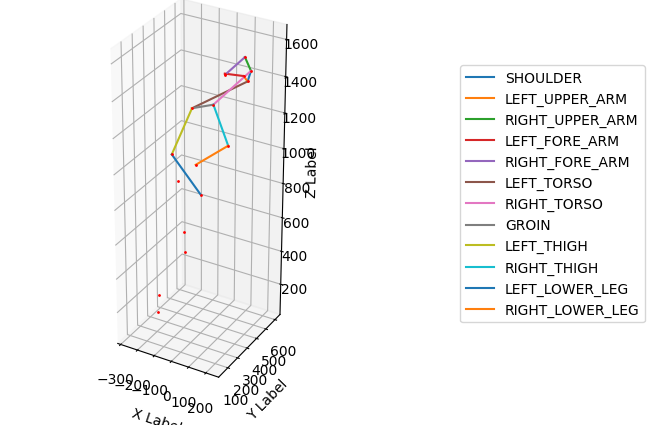

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for key, value in exp_keypoints_connections.items():
    start_idx = value[0]
    end_idx = value[1]
    ax.plot([pose_result[start_idx][0], pose_result[end_idx][0]],
            [pose_result[start_idx][1], pose_result[end_idx][1]],
            [pose_result[start_idx][2], pose_result[end_idx][2]], label=key)
for i in range(len(pose_result)):
    ax.scatter(pose_result[i][0], pose_result[i][1], pose_result[i][2], color='r', s=1)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
ax.set_aspect('equal')
plt.show()

In [25]:
columns = [f"{kpt}_{xyz}" for kpt in keypoints_17 for xyz in ["x", "y", "z"]]
# columns = [f"{kpt}_{xyz}" for kpt in key_point for xyz in ["x", "y", "z"]]
position_df = pd.DataFrame(columns=columns)
position_df.index.name = 'frame'
for frame in range(int(min_frame), int(max_frame) + 1):
    cam1_pose = cam1_position.loc[frame].values.reshape(-1, 2)  # Ensure reshaping to (-1, 3)
    cam2_pose = cam2_position.loc[frame].values.reshape(-1, 2)  # Ensure reshaping to (-1, 3)
    pose = np.array([cam1_pose, cam2_pose], dtype=np.float32)
    pose_result = pose_recon_2c(cam, P, pose)
    position_df.loc[frame] = pose_result.ravel()

### Figure

In [26]:
import pandas as pd

data_path = '3d_data/sasaki_3/sasaki_3_0.csv'
# df = pd.read_csv(data_path)
df = position_df
df

,NOSE_x,NOSE_y,NOSE_z,LEFT_EYE_x,LEFT_EYE_y,LEFT_EYE_z,RIGHT_EYE_x,RIGHT_EYE_y,RIGHT_EYE_z,LEFT_EAR_x,...,LEFT_KNEE_z,RIGHT_KNEE_x,RIGHT_KNEE_y,RIGHT_KNEE_z,LEFT_ANKLE_x,LEFT_ANKLE_y,LEFT_ANKLE_z,RIGHT_ANKLE_x,RIGHT_ANKLE_y,RIGHT_ANKLE_z
frame,,,,,,,,,,,,,,,,,,,,,
1,235.506130,336.861923,1504.423873,233.797430,372.277654,1544.231153,230.841607,305.588890,1545.305201,161.859283,...,523.481250,-41.412373,214.317129,536.720629,-280.128827,358.568411,119.080963,-200.276017,211.825809,127.044874
2,237.905757,335.770997,1504.246974,238.450863,369.530459,1543.916137,237.535556,304.791948,1545.009067,164.462765,...,522.110114,-41.063943,214.373381,531.935388,-282.121814,360.369221,117.822300,-199.830191,211.828574,127.277744
3,244.059109,336.506149,1504.281149,242.491391,368.438713,1542.104212,241.670943,303.533075,1543.992788,168.614016,...,523.253995,-36.609972,213.124799,532.457796,-279.878799,360.633482,118.205259,-200.219850,210.442659,126.253064
4,249.069578,332.709928,1503.981824,247.364697,368.145700,1540.920919,244.450653,301.373418,1543.794769,173.452963,...,522.566412,-34.379244,215.190910,530.827870,-279.748740,360.498062,118.523625,-202.434138,211.557699,127.290052
5,252.580254,333.274247,1503.376392,250.988748,365.139157,1540.154768,247.982833,301.957439,1543.152637,177.005276,...,523.976141,-32.482096,213.873890,535.019205,-280.220838,360.557858,120.801509,-198.315753,212.601614,127.915149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,4226.463359,-773.023955,1333.456127,4202.324184,-818.758497,1350.407127,4187.626105,-1041.780164,1344.707645,4170.983667,...,417.776906,4308.217504,44.784691,445.919176,4181.107505,397.318426,78.367326,4096.807526,173.734578,202.379756
328,4272.697281,-1179.498766,1135.399679,4224.876927,-1111.575683,1205.658146,4239.463588,-838.055530,1323.776413,4367.098897,...,397.479682,4291.535492,-78.666343,438.240523,4179.377181,467.411303,114.372009,4119.503461,183.713417,193.275404
329,4288.707528,-1325.591800,1126.517805,4191.732558,-1449.577683,1205.048541,4406.329308,-19.791700,1283.239448,4196.672670,...,437.699264,4297.775374,-8.745470,487.869150,4162.168870,448.866022,118.736764,4156.432133,202.826425,184.156283


<Axes: xlabel='frame'>

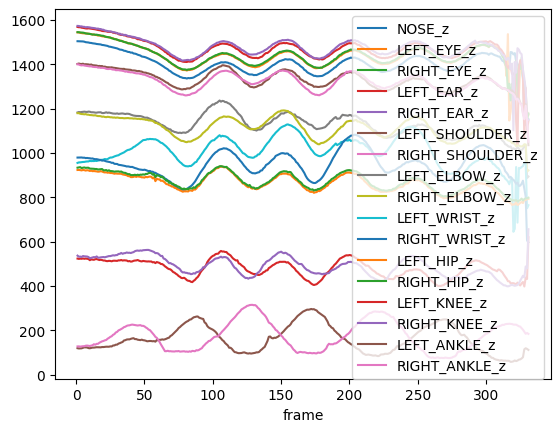

In [27]:
df_z = df.filter(like='_z')
df_z.plot()

In [28]:
key_point = ['SHOULDER', 'ELBOW', 'WRIST', 'HIP', 'KNEE', 'ANKLE']
cols = [c for c in df.columns if any(k in c for k in key_point) and 'acc' not in c]
pe_df = df[cols]
pe_df.reset_index(drop=True, inplace=True)

In [29]:
plot_3d_motion_exp(pe_df / 1000, graph_show=True)